<h1>学习方法：</h1>
- 1、边学边用，Torch只是个工具而已

<h1>Mnist分类任务：</h1>
<br/>1、网络基本构建与训练方法，常用函数解析
<br/>2、torch.nn.function模块
<br/>3、nn.Module模块

<h2>读取Mnist数据集：</h2>
<br/>会自动下载

In [3]:
import torch
print(torch.__version__)

2.0.1+cpu


In [4]:
%matplotlib inline

In [8]:
# 导入数据：
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [15]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

(50000, 784)


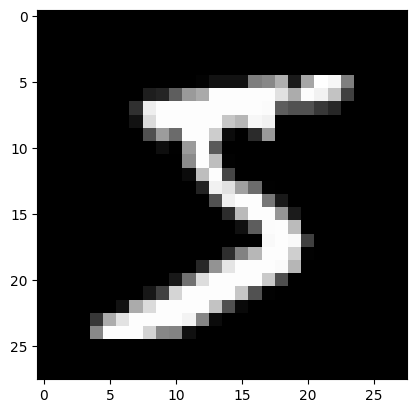

In [11]:
from matplotlib import pyplot
import numpy as np

# 画出灰度图：
pyplot.imshow(x_train[0].reshape((28,28)), cmap='gray')
print(x_train.shape) # 有 500000个样本，784是其特征，28 × 28 × 1 的图片    x_train[0] 是其中的一个样本

注意数据需转换成tensor才能参与后续建模训练

In [27]:
import torch
# 将数据格式映射为 tensor 的格式
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))


n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

C:\Users\LiuHao\AppData\Local\Temp\ipykernel_21884\4093566260.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [28]:
import torch.nn.functional as F

# 取到损失函数：
loss_func = F.cross_entropy

# 矩阵乘法： xw+b
def model(xb):
    return xb.mm(weights) + bias

In [29]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(12.2325, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码
- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [31]:
from torch import nn

# 定义网络结构：
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        # 输入 784 个像素点，输出128个特征，第一层        
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        # 最后输出 10 个类别
        self.out  = nn.Linear(256, 10)
        # 防止过拟合：
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [32]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


可以打印我们定义好名字里的权重和偏置项

In [33]:
for name, parameter in net.named_parameters():
    # name 是那一层     parameter 权重参数的值    parameter.size() 权重参数矩阵的大小
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[ 0.0227, -0.0247,  0.0106,  ...,  0.0284, -0.0268, -0.0165],
        [-0.0295, -0.0172,  0.0272,  ..., -0.0338,  0.0217, -0.0274],
        [-0.0188, -0.0159, -0.0136,  ...,  0.0100, -0.0310, -0.0010],
        ...,
        [ 0.0309,  0.0170,  0.0074,  ..., -0.0281,  0.0231, -0.0171],
        [-0.0180, -0.0313, -0.0261,  ..., -0.0277, -0.0148, -0.0082],
        [ 0.0055,  0.0082,  0.0296,  ..., -0.0084, -0.0241, -0.0029]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0173,  0.0257,  0.0186, -0.0266, -0.0046, -0.0303, -0.0118, -0.0044,
        -0.0310,  0.0330,  0.0289, -0.0175, -0.0070,  0.0046, -0.0064,  0.0085,
         0.0197, -0.0256, -0.0162,  0.0006, -0.0071, -0.0279, -0.0180,  0.0184,
        -0.0056, -0.0006, -0.0085, -0.0258, -0.0172,  0.0290, -0.0251,  0.0249,
         0.0057, -0.0130,  0.0202, -0.0136, -0.0307,  0.0250,  0.0216, -0.0199,
        -0.0189, -0.0318, -0.0340,  0.0132, 

### 使用TensorDataset和DataLoader来简化（了解）

In [35]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [36]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [38]:
import numpy as np

# 训练：训练轮数  模型  损失函数  优化器  训练集  测试集
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        # 验证模式不更新权重参数：
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [49]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.Adam(model.parameters(), lr=0.001)

In [50]:
# 1、计算损失 2、更新 w b
def loss_batch(model, loss_func, xb, yb, opt=None):
    # 预测值 和 真实值 求出损失
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [51]:
# 将数据进行分包：
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
# 拿到模型和优化器：
model, opt = get_model()
# 进行训练：
fit(100, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：0.15223033706992864
当前step:1 验证集损失：0.11245819904878736
当前step:2 验证集损失：0.10279250837266445
当前step:3 验证集损失：0.08979909717291594
当前step:4 验证集损失：0.09486353853009641
当前step:5 验证集损失：0.09730748088378459
当前step:6 验证集损失：0.09725826789867133
当前step:7 验证集损失：0.10056960283699445
当前step:8 验证集损失：0.09496430078530683
当前step:9 验证集损失：0.10042552438732237
当前step:10 验证集损失：0.10431984464609705
当前step:11 验证集损失：0.10176561226415215
当前step:12 验证集损失：0.12788148235137634
当前step:13 验证集损失：0.12286423763319618
当前step:14 验证集损失：0.11788142966383602
当前step:15 验证集损失：0.11963363941271091
当前step:16 验证集损失：0.11651170748299046
当前step:17 验证集损失：0.1712689236845821
当前step:18 验证集损失：0.13933050909949235
当前step:19 验证集损失：0.12337002182076685
当前step:20 验证集损失：0.13693664496375332
当前step:21 验证集损失：0.14421802502000683
当前step:22 验证集损失：0.13896525131023227
当前step:23 验证集损失：0.13625350249484872
当前step:24 验证集损失：0.15268941241114445
当前step:25 验证集损失：0.15922742686214333
当前step:26 验证集损失：0.14600773748431967
当前step:27 验证集损失：0.1554873085472813
当前st

算准确率：

In [52]:
correct = 0
total = 0
for xb, yb in valid_dl:
    outputs = model(xb)
    _, predicted = torch.max(outputs.data, 1) # 最大值，索引
    total += yb.size(0)
    correct += (predicted == yb).sum().item()
    
print('Accuracy of network on the 10000 test images: %d %%'%(100 * correct / total))

Accuracy of network on the 10000 test images: 97 %


### 练习：
- 1、将优化器由 SGD 改为 Adam
- 2、更改网络层数和神经元个数观察效果
- 3、计算当前模型的准确率等于多少

- SGD 一百次，准确率 93%, 损失大于 0.22
- Adam 一百次，准确率 97%, 损失大于 0.27